In [2]:
import numpy as np
import pandas as pd
from IPython.display import Image

In [3]:
import os
import tensorflow as tf
import keras
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *

# Explore data
- Lokaler Dateipfad zu dem FER Datensatz
- Lokale Variable für die Image Größe und Batch Size
- Wir unterteilen die Daten nach Traininings- und Testdaten. Die Testdaten sind unabhängig von den Trainingsdaten und ermöglichen eine Evaluation der Modellleistung. 

In [105]:
img_shape = 48
batch_size = 64
train_data_path = '../data/train/'
test_data_path = '../data/test/'

- 1 Beispielbild für jede Emotion aus dem Test Datensatz
- Größe der Bilder 48*48 Pixel in Graustufen

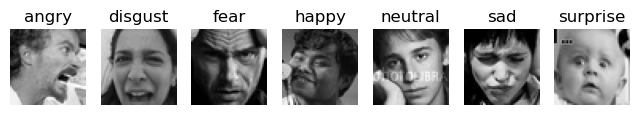

In [108]:
i = 1
plt.figure(figsize=(8,8))
for expression in os.listdir(test_data_path):
    
    img = load_img((test_data_path + expression +'/'+ os.listdir(test_data_path + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

- Klassenverteilung im Trainigsdatensatz unbalanciert.
- Mögliche Gegenmaßnahmen: Data Augmentation für Disgust, Random Oversampling für Disgust, Random Undersampling für alle anderen Klassen, Weitere Daten sammeln

In [110]:
for expression in os.listdir(train_data_path):
    print(expression, "folder contains:   ", len(os.listdir(train_data_path + expression)), "images")

angry folder contains:    3995 images
disgust folder contains:    436 images
fear folder contains:    4097 images
happy folder contains:    7215 images
neutral folder contains:    4965 images
sad folder contains:    4830 images
surprise folder contains:    3171 images


# Transform and load data 
- Klasse ImageDataGenerator lädt Bilddaten in Batches aus Verzeichnis und übernimmt Umwandlung/Rescaling der Bildwerte.
- Um das Auswendiglernen von Bildern zu verhindern werden die Orginalbilder aus dem Trainingsdatensatz "on the fly" variiert: Zoom, Höhe oder Breite verändern und auffüllen, Rotieren

In [111]:
train_gen = ImageDataGenerator(
        rescale= 1 / 255,
        # Data Augmentation
        rotation_range=10,
        zoom_range= 0.2,
        width_shift_range= 0.1,
        height_shift_range= 0.1,
        fill_mode ="nearest"
    )

train_data = train_gen.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='grayscale', 
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)

test_gen = ImageDataGenerator(rescale= 1 / 255 )

test_data = test_gen.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="grayscale",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


- Resultat: Interne Darstellung der Bilder als Vektor mit Werten zwischen 0 und 1

In [122]:
img_path='../data/test/happy/PrivateTest_10077120.jpg'
test_image = image.load_img(img_path, target_size=(48,48), color_mode='grayscale') 
test_image = image.img_to_array(test_image) / 255

print(f'Interne Darstellung der Bilder als Vektor mit {test_image.size} Werten zwischen 0 und 1')
print(f'Beispiel: {test_image[0][0:10]}')

Interne Darstellung der Bilder als Vektor mit 2304 Werten zwischen 0 und 1
Beispiel: [[0.78431374]
 [0.8156863 ]
 [0.7294118 ]
 [0.7019608 ]
 [0.6784314 ]
 [0.627451  ]
 [0.7294118 ]
 [0.7176471 ]
 [0.41568628]
 [0.7019608 ]]


# Create CNN
- Definition der Architektur
    - Conv2D (Convolution Layer): Diese Ebene enthält Filter der Größe 3x3. Diese Filter erkennen jeweils bestimmte Muster (z.B. waagerechte Striche). Wird das Muster gefunden, meldet das Neuron das Ergebnis weiter. <br>
    <img src="Convolution_2.png" alt="Drawing" style="width: 600px;"/>

    - MaxPooling2D: Durch das Wählen der größen Werte aus einem 2x2 Filter wird die Auflösung im Netz herunterskaliert und gleichzeitig die wichtigsten Informationen behalten. Es passiert ein fokussieren auf entscheidende "Details", z.B. scharfe Kanten betrachtet werden. <br>
    <img src="MaxPooling.png" alt="Drawing" style="width: 400px;"/>

    - Dropout: Setzt während dem Training zufällig 25% der Signale auf 0. Dies verhindert das "Auswendiglernen" der Trainingsdaten.
    - Flatten: Reduziert eine Matrix (zwei Dimensionen) zu einem einzigen Array.
    - Batch Normalization: Normalisiert den Output des vorherigen Layers.
    - Dense: Standard Feed Forward Netz

In [123]:
def Create_CNN_Model():
    
    model = Sequential()
    
    #CNN
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(img_shape, img_shape, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #Output
    model.add(Flatten())
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(7,activation='softmax'))
    
    
    return model

In [124]:
CNN_Model = Create_CNN_Model()

CNN_Model.summary()

CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_19 (Bat  (None, 46, 46, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_20 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                      

# Train and Save CNN
- Training des Neural Nets auf dem FER Datensatz.

In [88]:
steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

CNN_history = CNN_Model.fit(train_data, 
                            validation_data = test_data,
                            epochs = 30, 
                            batch_size = batch_size,
                            steps_per_epoch = steps_per_epoch, 
                            validation_steps = validation_steps
                           )

CNN_Model.save("emotion_model.h5")

Epoch 1/30
448/448 [==============================] - 99s 217ms/step - loss: 1.9046 - accuracy: 0.2676 - val_loss: 1.7612 - val_accuracy: 0.2900
Epoch 2/30
448/448 [==============================] - 95s 211ms/step - loss: 1.6568 - accuracy: 0.3543 - val_loss: 1.5897 - val_accuracy: 0.3864
Epoch 3/30
448/448 [==============================] - 93s 208ms/step - loss: 1.5768 - accuracy: 0.3891 - val_loss: 1.4368 - val_accuracy: 0.4457
Epoch 4/30
448/448 [==============================] - 102s 227ms/step - loss: 1.5292 - accuracy: 0.4092 - val_loss: 1.7266 - val_accuracy: 0.3386
Epoch 5/30
448/448 [==============================] - 95s 211ms/step - loss: 1.4982 - accuracy: 0.4200 - val_loss: 1.4703 - val_accuracy: 0.4348
Epoch 6/30
448/448 [==============================] - 93s 208ms/step - loss: 1.4741 - accuracy: 0.4299 - val_loss: 1.4413 - val_accuracy: 0.4495
Epoch 7/30
448/448 [==============================] - 94s 210ms/step - loss: 1.4529 - accuracy: 0.4397 - val_loss: 1.4526 - val_a

# Evaluate CNN
- Accuracy nach 30 Epochen Training ist 53% auf dem Testdatensatz. Dies bedeutet, dass ca. die Hälte der Bilder aus dem Testdatensatz die korrekte Emotion zugeordnet bekommen haben.

In [95]:
CNN_Score = CNN_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

113/113 [==============================] - 5s 40ms/step - loss: 1.1962 - accuracy: 0.5393
    Test Loss: 1.19617
Test Accuracy: 53.93%


- Entwicklung der Accuracy und Trainings Loss über die Epochen hinweg: Es ist wahrscheinlich, dass durch mehr Epochen noch leichte Verbesserungen erzielt werden können.

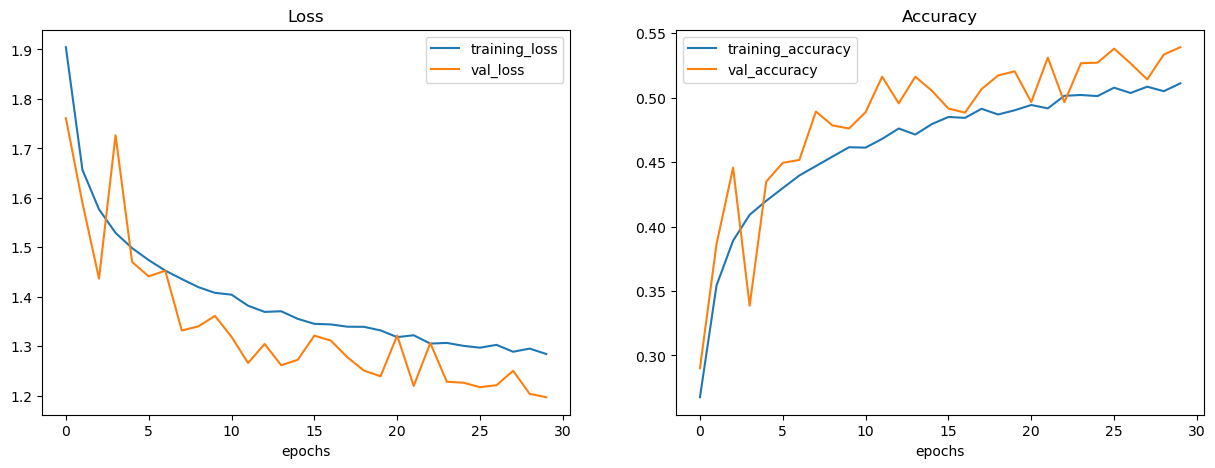

In [96]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

import matplotlib.pyplot as plt
plot_curves(CNN_history)

- Die Confusion zeigt, welche Emotionen für welche wahren Emotionen erkannt wurden.

Text(0.5, 1.0, 'CNN Confusion Matrix')

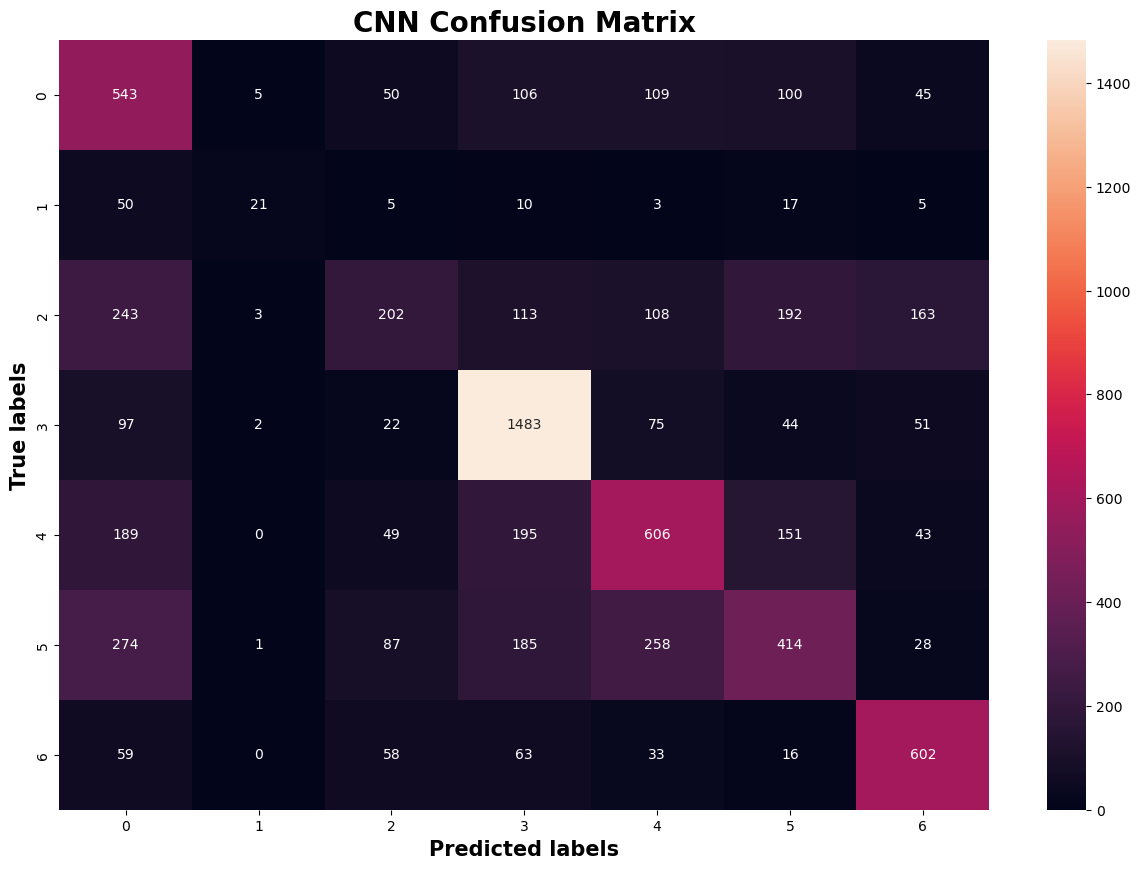

In [99]:
CNN_Predictions = CNN_Model.predict(test_data)
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

- Classification Report liefert die wichtigsten Kennzahlen aufgeschlüsselt nach den einzelnen Klassen.  

In [100]:
report = classification_report(test_data.classes, CNN_Predictions)
print(report)

              precision    recall  f1-score   support

           0       0.37      0.57      0.45       958
           1       0.66      0.19      0.29       111
           2       0.43      0.20      0.27      1024
           3       0.69      0.84      0.75      1774
           4       0.51      0.49      0.50      1233
           5       0.44      0.33      0.38      1247
           6       0.64      0.72      0.68       831

    accuracy                           0.54      7178
   macro avg       0.53      0.48      0.48      7178
weighted avg       0.53      0.54      0.52      7178



# Test predict model
- Das gespeicherte Modell und ein Beispielbild werden geladen und ausgeführt.

In [9]:
emotion_model = keras.models.load_model('emotion_model.h5')

(48, 48, 1)


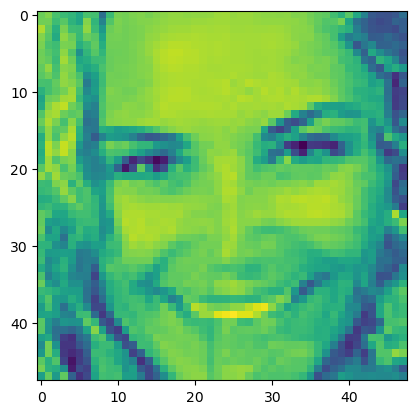

In [10]:
img_path='../data/test/happy/PrivateTest_10077120.jpg'
test_image = image.load_img(img_path, target_size=(48,48), color_mode='grayscale') 
test_image = image.img_to_array(test_image) / 255
print(test_image.shape)
plt.imshow(test_image)
plt.show()

In [11]:
test_image=test_image.reshape(1,48,48,1)
classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
result=emotion_model.predict(test_image)
print(result[0])
y_pred=np.argmax(result[0])
print('The person facial emotion is:',classes[y_pred])

1/1 [==============================] - 0s 168ms/step
[9.2656224e-04 3.5881042e-04 7.6474965e-04 9.8821056e-01 2.4811183e-03
 2.3545133e-04 7.0227184e-03]
The person facial emotion is: Happy
